In [84]:
# all tensorflow api is accessible through this
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt 
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data
tf.set_random_seed(0)

# load data
mnist = input_data.read_data_sets('input/data', one_hot=True)

Extracting input/data\train-images-idx3-ubyte.gz
Extracting input/data\train-labels-idx1-ubyte.gz
Extracting input/data\t10k-images-idx3-ubyte.gz
Extracting input/data\t10k-labels-idx1-ubyte.gz


In [113]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

## Define Varibales and Placeholders

In [114]:
xx = tf.placeholder(tf.float32, [None, 28, 28, 1])
x = tf.reshape(xx, [-1, 784]) 
y=tf.placeholder(tf.float32, [None, 10])
pkeep = tf.placeholder(tf.float32)

In [126]:
Weights = {
    
    'W1': tf.Variable(tf.random_normal([784, 200])),
    'W2': tf.Variable(tf.random_normal([200, 100])),
    'W3': tf.Variable(tf.random_normal([100, 60])),
    'W4': tf.Variable(tf.random_normal([60, 30])),
    'W5': tf.Variable(tf.random_normal([30, 10])),

}

biases = {
    
    'b1': tf.Variable(tf.zeros([200])),
    'b2': tf.Variable(tf.zeros([100])),
    'b3': tf.Variable(tf.zeros([60])),
    'b4': tf.Variable(tf.zeros([30])),
    'b5': tf.Variable(tf.zeros([10]))
}

## Define the model

In [137]:
def model(XX, Weights, biases, dropout, activation):
    Y1 = activation(tf.matmul(XX, Weights['W1']) + biases['b1'])
    Y1 = tf.nn.dropout(Y1, dropout)
      
    Y2 = activation(tf.matmul(Y1, Weights['W2']) + biases['b2'])
    Y2 = tf.nn.dropout(Y2, dropout)
    
    Y3 = activation(tf.matmul(Y2, Weights['W3']) + biases['b3'])
    Y3 = tf.nn.dropout(Y3, dropout)
    
    Y4 = activation(tf.matmul(Y3, Weights['W4']) + biases['b4'])
    Y4 = tf.nn.dropout(Y4, dropout)
    
    #out = tf.nn.softmax(tf.matmul(Y4, Weights['W5']) + biases['b5'])
    out = tf.matmul(Y4, Weights['W5']) + biases['b5']
    
    return out


In [138]:
# 3. Define the loss function  
Ylogits = model(x, Weights, biases, pkeep, activation=tf.sigmoid) #tf.sigmoid ; tf.nn.relu
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits , labels=y))

In [139]:
# 4. Define the accuracy 
correct_prediction = tf.equal(tf.argmax(Ylogits , 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [140]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.005
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.99, staircase=True)

In [141]:
# 5. Define an optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy,global_step)
#optimizer = tf.train.AdamOptimizer(0.005).minimize(cross_entropy)

In [142]:
# initialize
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [143]:
dropout = 0.75 
def training_step(i, update_test_data, update_train_data):

    #print ("\r", i),
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    # the backpropagation training step
    sess.run(optimizer, feed_dict={x: batch_X, y: batch_Y,pkeep: dropout})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={x: batch_X, y: batch_Y,pkeep: 1.0})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={x: mnist.test.images, y: mnist.test.labels,pkeep: 1.0})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)


In [144]:
# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 10000
epoch_size = 100
for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    (a, c, ta, tc) = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc

In [145]:
print('Max test accuracy ' + str(max(test_a)))
print('Min test loss ' + str(min(test_c)))
print('Final test loss ' + str(test_a[-1]))
print('Final test loss ' + str(test_c[-1]))

Max test accuracy 0.8386
Min test loss 0.461152
Final test loss 0.8353
Final test loss 0.461577


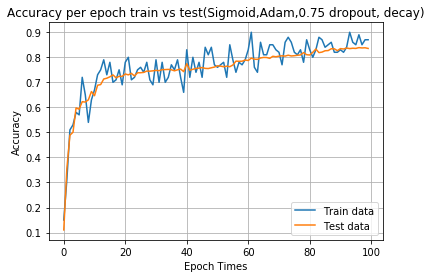

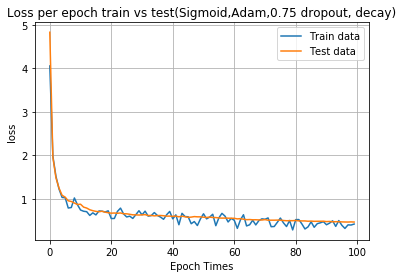

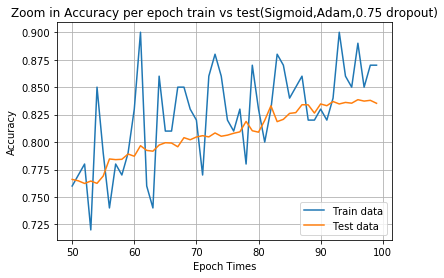

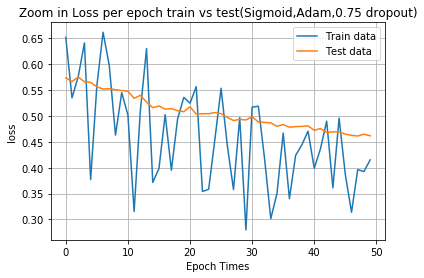

In [147]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a, label='Train data')
plt.plot(test_a, label='Test data')
plt.xlabel('Epoch Times')
plt.ylabel('Accuracy')
plt.grid(True)
plt.title('Accuracy per epoch train vs test(Sigmoid,Adam,0.75 dropout, decay)')
plt.legend()
plt.show()

# loss training vs testing dataset
plt.plot(train_c,label='Train data')
plt.plot(test_c,label='Test data')
plt.xlabel('Epoch Times')
plt.ylabel('loss')
plt.title('Loss per epoch train vs test(Sigmoid,Adam,0.75 dropout, decay)')
plt.grid(True)
plt.legend()
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,100)
plt.plot(x_range, train_a[zoom_point:],label='Train data')
plt.plot(x_range, test_a[zoom_point:],label='Test data')
plt.xlabel('Epoch Times')
plt.ylabel('Accuracy')
plt.title('Zoom in Accuracy per epoch train vs test(Sigmoid,Adam,0.75 dropout)')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(train_c[zoom_point:],label='Train data')
plt.plot(test_c[zoom_point:],label='Test data')
plt.xlabel('Epoch Times')
plt.ylabel('loss')
plt.title('Zoom in Loss per epoch train vs test(Sigmoid,Adam,0.75 dropout)')
plt.grid(True)
plt.legend()
plt.show()

In [98]:
print(max(test_a))

0.8365
